# OTIM-DB linear fit in log-space

We fit a linear relationship in log space between the tension (h positive in mm) and the unsaturated hydraulic conductivity (K in mm.h-1). We use K with tension < 5 mm (included Ks) to compute a plateau. The other values are used to compute a linear fit in loglog space.
- If there are more than 3 data points, we remove the one at the lowest tension (closer to saturation) if below 0.5 cm and use it afterwards to compute the Hmin. If it's tension is above 0.5 mm then we keep it in the fit.
- If the slope and the K10 (K at 10 cm tension) is already given, then we use them to compute the intercept with Kunsat at 10 cm

In all cases, we use the intercept and the slope to compute tensions at 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 cm if they are in the interval between Tmin and Tmax both included. If Tmax >= 8 cm, we extrapolate up to h = 10 cm.

Nick's rules:
- no estimation of Ks unless there is a data point at h<=5 mm
- no estimation of K10 unless there is a data point at h>= 80 mm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

datadir = '../data/'
figdir = '../figures/'

In [2]:
# read in OTIM database
dfdic = pd.read_excel(datadir + 'OTIM-DB.xlsx', sheet_name=None, na_values=-9999)
dfmtf = pd.merge(dfdic['method'], dfdic['modelFit'], left_on='MethodName', right_on='MTFName', how='left')
dfmtf = dfmtf.rename(columns={'MTFID_x': 'MTFID'})
# don't replace as it makes empty cells on export then or merged cell -> a mess!
dfraw = dfdic['rawData']

C:\Users\johnk\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:296: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  warn(msg)
C:\Users\johnk\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [3]:
# all tensions as positive number
print('number of negative tensions (should be 0):', dfraw['h (cm)'].lt(0).sum())
dfraw['h (cm)'] = dfraw['h (cm)'].abs()

# old entries have no raw data (we used the existing slope and intercept)
dfmtf['old'] = ~dfmtf['MTFName'].isin(dfraw['MTFName'])

# old entries with an Hmin should have a Ks value
# new entries can have an Hmin and a Ks value but it comes from the fit of raw data (below)
print('number of old entries with Hmin but no Ks (should be 0): ', 
      (dfmtf['old'] & dfmtf['Ks'].isna() & dfmtf['Hmin'].notnull()).sum())

# some entries mention Tmin = 0 but don't have Ks
print('number of old entries with Tmin <= 5 mm but no Ks: ',
      (dfmtf['old'] & dfmtf['Tmin'].le(5) & dfmtf['Ks'].isna()).sum())

# Ks available but Tmin > 5 mm
print('number of old entries with Tmin > 5 mm with Ks: ',
      (dfmtf['old'] & dfmtf['Tmin'].gt(5) & dfmtf['Ks'].notnull()).sum())

number of negative tensions (should be 0): 0
number of old entries with Hmin but no Ks (should be 0):  0
number of old entries with Tmin <= 5 mm but no Ks:  72
number of old entries with Tmin > 5 mm with Ks:  143


In [4]:
ie = dfmtf['old'] & dfmtf['Tmin'].lt(5) & dfmtf['Ks'].notnull()
dfmtf[ie][['MTFName', 'Tmin', 'Tmax', 'Ks', 'Hmin', 'K10', 'K20']]

,MTFName,Tmin,Tmax,Ks,Hmin,K10,K20
0,Bod1NatGrass,0.0,220.0,103.5459,12.0,103.5459,50.131140
1,Bod1BroGrass,0.0,220.0,112.6093,11.0,112.6093,46.207726
2,Bod1CulCan,0.0,220.0,27.3088,10.0,27.3088,14.838709
4,CamConvTillMay,0.0,150.0,162.0016,10.0,162.0016,67.175539
5,CamConvTillJune,0.0,150.0,74.6669,10.0,74.6669,40.012976
...,...,...,...,...,...,...,...
753,Raoof20,0.0,150.0,15.3857,34.0,15.3857,15.385700
754,Raoof30,0.0,150.0,14.5683,34.0,14.5683,14.568300
755,Raoof40,0.0,150.0,13.8709,39.0,13.8709,13.870900
757,DasGupta20,0.0,200.0,46.7000,38.0,46.7000,46.700000


In [5]:
# fit linear relationship in loglog space for raw data
tensions = np.arange(1, 11)*10  # mm
kcols = ['K{:.0f}'.format(t) for t in tensions]
logdic = {'not enough h > 5 mm': [], 'hmin < max(h of plateau)': [], 'fit failed': [],
          'only one tension': [], 'kunsat unknown for old entries': []}
for i, mtfName in enumerate(dfmtf['MTFName']):
    # we have raw data so let's fit a relationship
    ie = dfraw['MTFName'] == mtfName
    ok = False
    oo = False

    # we need at least two values to fit a line
    if np.sum(ie) > 1:
        ok = True
        kunsat = dfraw[ie]['K (mm.h-1)'].values
        h = dfraw[ie]['h (cm)'].values*10  # mm
        isort = np.argsort(h)

        # if Ksat is available we keep and set it to a very small tension
        if h[isort][0] == 0:
            h[isort[0]] = 1  # a very small tension for Ks

        # values are sorted from lowest 0 cm to highest tension 10 cm
        x = h[isort]
        y = kunsat[isort]

        # we compute a plateau (and Ks) if we have tension(s) <= 5 mm
        hplateau = 5
        iplateau = x <= hplateau
        if np.sum(iplateau) > 0:
            ksat = np.mean(y[iplateau])
        else:
            ksat = None

        # extend the plateau if the next tension is greater than extimated ksat (e.g. Bodner2013)
#         if ksat is not None:
#             if y[~iplateau][0] > np.min(y[iplateau]):
#                 print('+++', mtfName, x[iplateau], x[x > hplateau])
#                 hplateau = h[~iplateau][0]
#                 iplateau = x <= hplateau
#                 ksat = np.mean(y[iplateau])
#                 oo = True

        # linear fit in log-log space
        # we do not include 5 mm for the fit
        ifit = x > hplateau
        if np.sum(ifit) < 2:  # then we take them all even Ks (e.g. holden2014)
            ifit = np.ones(len(x), dtype=bool)
            logdic['not enough h > 5 mm'].append(mtfName)
        slope, intercept, r, p, se = stats.linregress(
            np.log10(x[ifit]), np.log10(y[ifit]))
        #print(x[ifit], x[iplateau])

        # with the plateau (Ksat) and the fit we compute Hmin
        if np.sum(iplateau) > 0:
            hmin = 10**((np.log10(ksat) - intercept)/slope)
            if hmin < np.max(x[iplateau]):  # this is wrong (e.g. lozano2014)
                hmin = None
                slope, intercept, r, p, se = stats.linregress(
                    np.log10(x), np.log10(y))
                logdic['hmin < max(h of plateau)'].append(mtfName)
        else:
            hmin = None

        # check if the fit failed
        if pd.isna(intercept):
            logdic['fit failed'].append((mtfName, x, y))

    # if there is no rawData, this is an old entry
    # we compute back the intercept from kunsat (k at 10 cm tension)
    elif np.sum(ie) == 0:
        ok = True
        if pd.isna(dfmtf.loc[i, 'Kunsat']) is False:
            k10 = dfmtf.loc[i, 'Kunsat']
            # slope is reported as positive number in the db
            slope = - dfmtf.loc[i, 'slope']
            intercept = np.log10(k10) - slope * np.log10(100)
            dfmtf.loc[i, 'intercept'] = intercept
            hmin = dfmtf.loc[i, 'Hmin']  # from the fit in the original Jorda database
            ksat = dfmtf.loc[i, 'Ks']  # from the fit in the original Jorda database
        else:
            slope, intercept = np.nan, np.nan
            logdic['kunsat unknown for old entries'].append(mtfName)

    else:
        logdic['only one tension'].append(mtfName)

    if ok is True:
        # build fpred() function
        def fpred(hh):
            if pd.isna(hmin) is False:
                if hh <= hmin:
                    return ksat
                else:
                    return 10**(intercept + slope * np.log10(hh))
            else:
                return 10**(intercept + slope * np.log10(hh))

        # estimate K for other tensions between Tmin and Tmax
        Tmin = dfmtf.loc[i, 'Tmin']  # mm
        Tmax = dfmtf.loc[i, 'Tmax']
        if Tmax >= 80:  # allow extrapolation if Tmax is 80 mm or more
            Tmax = 100
        kvals = [np.nan]*len(tensions)
        for j, tension in enumerate(tensions):
            if (tension >= Tmin) & (tension <= Tmax):
                kvals[j] = fpred(tension)
        dfmtf.loc[i, kcols] = kvals
        dfmtf.loc[i, 'Ks'] = ksat  # overwrite Ks with NaN if Tmin > 5 mm

        # only for new entries
        if np.sum(ie) > 0:
            # save them into the database
            dfmtf.loc[i, ['Ks', 'Kunsat', 'slope', 'intercept', 'R2', 'Hmin']] = [
                ksat, None, slope*-1, intercept, r**2, hmin]

            if False:  # change to False to prevent plotting
                fig, ax = plt.subplots()
                ax.set_title(mtfName)
                ax.loglog(x, y, 'ko')
                if x[0] == 0.1:
                    ax.loglog(x[0], y[0], 'ro', label='Ks')
                ax.set_xlabel('h [mm]')
                ax.set_ylabel(r'K [mm.h$^{-1}$]')
                if hmin is not None:
                    ax.axvline(hmin, linestyle=':', color='k', label='Hmin')
                    xx = np.sort(np.r_[x, hmin])
                else:
                    xx = x
                ax.loglog(xx, [fpred(a) for a in xx], 'k-', 
                          label='Slope: {:.2f}\nR$^2$={:.2f}'.format(slope, r**2))
                ax.legend()
                plt.show()

dfmtf[dfdic['modelFit'].columns].to_excel(datadir + 'dfmtf.xlsx', index=False)
logdic

interestings = dfmtf['Tmax'].ge(80) & dfmtf['Tmax'].ge(80)
dout = dfmtf[interestings]

In [6]:
# fit linear relationship in loglog space for raw data.. but discard all tensions > 60 mm
i2keep = dfraw['h (cm)'].le(6)
dfraw = dfraw[i2keep]

dfmtf2 = dfmtf.copy()

tensions = np.arange(1, 11)*10  # mm
kcols = ['K{:.0f}'.format(t) for t in tensions]
logdic = {'not enough h > 5 mm': [], 'hmin < max(h of plateau)': [], 'fit failed': [],
          'only one tension': [], 'kunsat unknown for old entries': []}
for i, mtfName in enumerate(dfmtf2['MTFName']):
    # we have raw data so let's fit a relationship
    ie = dfraw['MTFName'] == mtfName
    ok = False
    oo = False

    # we need at least two values to fit a line
    if np.sum(ie) > 1:
        ok = True
        kunsat = dfraw[ie]['K (mm.h-1)'].values
        h = dfraw[ie]['h (cm)'].values*10  # mm
        isort = np.argsort(h)

        # if Ksat is available we keep and set it to a very small tension
        if h[isort][0] == 0:
            h[isort[0]] = 1  # a very small tension for Ks

        # values are sorted from lowest 0 cm to highest tension 10 cm
        x = h[isort]
        y = kunsat[isort]

        # we compute a plateau (and Ks) if we have tension(s) <= 5 mm
        hplateau = 5
        iplateau = x <= hplateau
        if np.sum(iplateau) > 0:
            ksat = np.mean(y[iplateau])
        else:
            ksat = None

        # extend the plateau if the next tension is greater than extimated ksat (e.g. Bodner2013)
#         if ksat is not None:
#             if y[~iplateau][0] > np.min(y[iplateau]):
#                 print('+++', mtfName, x[iplateau], x[x > hplateau])
#                 hplateau = h[~iplateau][0]
#                 iplateau = x <= hplateau
#                 ksat = np.mean(y[iplateau])
#                 oo = True

        # linear fit in log-log space
        # we do not include 5 mm for the fit
        ifit = x > hplateau
        if np.sum(ifit) < 2:  # then we take them all even Ks (e.g. holden2014)
            ifit = np.ones(len(x), dtype=bool)
            logdic['not enough h > 5 mm'].append(mtfName)
        slope, intercept, r, p, se = stats.linregress(
            np.log10(x[ifit]), np.log10(y[ifit]))
        #print(x[ifit], x[iplateau])

        # with the plateau (Ksat) and the fit we compute Hmin
        if np.sum(iplateau) > 0:
            hmin = 10**((np.log10(ksat) - intercept)/slope)
            if hmin < np.max(x[iplateau]):  # this is wrong (e.g. lozano2014)
                hmin = None
                slope, intercept, r, p, se = stats.linregress(
                    np.log10(x), np.log10(y))
                logdic['hmin < max(h of plateau)'].append(mtfName)
        else:
            hmin = None

        # check if the fit failed
        if pd.isna(intercept):
            logdic['fit failed'].append((mtfName, x, y))

    # if there is no rawData, this is an old entry
    # we compute back the intercept from kunsat (k at 10 cm tension)
    elif np.sum(ie) == 0:
        ok = True
        if pd.isna(dfmtf2.loc[i, 'Kunsat']) is False:
            k10 = dfmtf2.loc[i, 'Kunsat']
            # slope is reported as positive number in the db
            slope = - dfmtf2.loc[i, 'slope']
            intercept = np.log10(k10) - slope * np.log10(100)
            dfmtf2.loc[i, 'intercept'] = intercept
            hmin = dfmtf2.loc[i, 'Hmin']  # from the fit in the original Jorda database
            ksat = dfmtf2.loc[i, 'Ks']  # from the fit in the original Jorda database
        else:
            slope, intercept = np.nan, np.nan
            logdic['kunsat unknown for old entries'].append(mtfName)

    else:
        logdic['only one tension'].append(mtfName)

    if ok is True:
        # build fpred() function
        def fpred(hh):
            if pd.isna(hmin) is False:
                if hh <= hmin:
                    return ksat
                else:
                    return 10**(intercept + slope * np.log10(hh))
            else:
                return 10**(intercept + slope * np.log10(hh))

        # estimate K for other tensions between Tmin and Tmax
        Tmin = dfmtf2.loc[i, 'Tmin']  # mm
        Tmax = dfmtf2.loc[i, 'Tmax']
        if Tmax >= 80:  # allow extrapolation if Tmax is 80 mm or more
            Tmax = 100
        kvals = [np.nan]*len(tensions)
        for j, tension in enumerate(tensions):
            if (tension >= Tmin) & (tension <= Tmax):
                kvals[j] = fpred(tension)
        dfmtf2.loc[i, kcols] = kvals
        dfmtf2.loc[i, 'Ks'] = ksat  # overwrite Ks with NaN if Tmin > 5 mm

        # only for new entries
        if np.sum(ie) > 0:
            # save them into the database
            dfmtf2.loc[i, ['Ks', 'Kunsat', 'slope', 'intercept', 'R2', 'Hmin']] = [
                ksat, None, slope*-1, intercept, r**2, hmin]

            if False:  # change to False to prevent plotting
                fig, ax = plt.subplots()
                ax.set_title(mtfName)
                ax.loglog(x, y, 'ko')
                if x[0] == 0.1:
                    ax.loglog(x[0], y[0], 'ro', label='Ks')
                ax.set_xlabel('h [mm]')
                ax.set_ylabel(r'K [mm.h$^{-1}$]')
                if hmin is not None:
                    ax.axvline(hmin, linestyle=':', color='k', label='Hmin')
                    xx = np.sort(np.r_[x, hmin])
                else:
                    xx = x
                ax.loglog(xx, [fpred(a) for a in xx], 'k-', 
                          label='Slope: {:.2f}\nR$^2$={:.2f}'.format(slope, r**2))
                ax.legend()
                plt.show()

dfmtf2[dfdic['modelFit'].columns].to_excel(datadir + 'dfmtf_special.xlsx', index=False)

dout2 = dfmtf2[interestings]

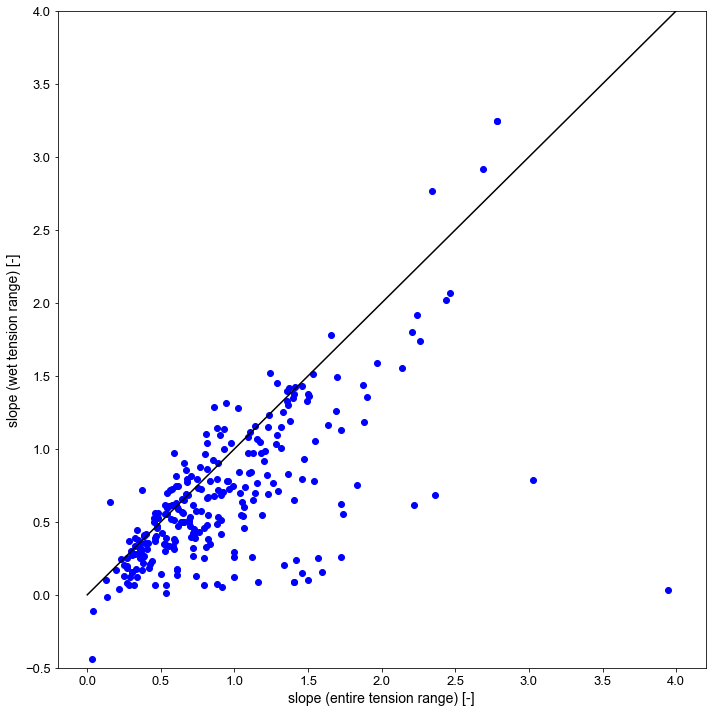

In [7]:
keeps = dout['slope'].ne(dout2['slope'])
dout = dout[keeps]
dout2=dout2[keeps]
x = dout['slope'].values
y = dout2['slope'].values

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(x,y,'bo')
plt.plot([0,4],[0,4],'-k')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)
ax.set_ylim([-0.5, 4])
ax.set_ylim([-0.5, 4])
ax.set_xlabel('slope (entire tension range) [-]', fontname='Arial', fontsize=14)
ax.set_ylabel('slope (wet tension range) [-]', fontname='Arial', fontsize=14)
fig.tight_layout()
fig.savefig(figdir + 'bias.jpg', dpi=500)

[10. 30. 50.] [5.]
[30. 60.] [1.]


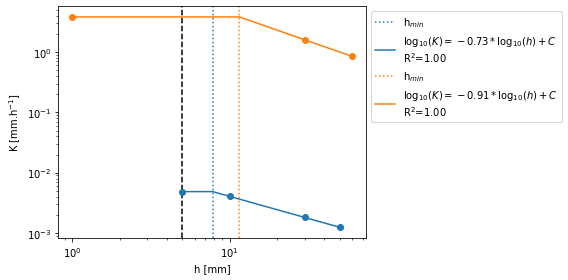

In [8]:
# example for the data in brief paper
fig, ax = plt.subplots(figsize=(8, 4))
ax.axvline(5, color='k', linestyle='--')
tensions = np.arange(1, 11)*10  # mm
kcols = ['k{:.0f}'.format(t/10) for t in tensions]
logdic = {'not enough h > 5 mm': [], 'hmin < max(h of plateau)': [], 'fit failed': [],
          'only one tension': [], 'kunsat unknown for old entries': []}
spub = ['Rahbeh2019_S56', 'zhao2014_wet_acl16', 'deboever2016_Canopy_MCD']
for i, mtfName in enumerate(dfmtf[dfmtf['MTFName'].isin(spub)]['MTFName']):
    # we have raw data so let's fit a relationship
    ie = dfraw['MTFName'] == mtfName
    ok = False
    oo = False

    # we need at least two values to fit a line
    if np.sum(ie) > 1:
        ok = True
        kunsat = dfraw[ie]['K (mm.h-1)'].values
        h = dfraw[ie]['h (cm)'].values*10  # mm
        isort = np.argsort(h)

        # if Ksat is available we keep and set it to a very small tension
        if h[isort][0] == 0:
            h[isort[0]] = 1  # a very small tension for Ks

        # values are sorted from lowest 0 cm to highest tension 10 cm
        x = h[isort]
        y = kunsat[isort]

        # we compute a plateau (and Ks) if we have tension(s) <= 5 mm
        hplateau = 5
        iplateau = x <= hplateau
        if np.sum(iplateau) > 0:
            ksat = np.mean(y[iplateau])
        else:
            ksat = None

        # extend the plateau if the next tension is greater than extimated ksat (e.g. Bodner2013)
#         if ksat is not None:
#             if y[~iplateau][0] > np.min(y[iplateau]):
#                 print('+++', mtfName, x[iplateau], x[x > hplateau])
#                 hplateau = h[~iplateau][0]
#                 iplateau = x <= hplateau
#                 ksat = np.mean(y[iplateau])
#                 oo = True

        # linear fit in log-log space
        # we do not include 5 mm for the fit
        ifit = x > hplateau
        if np.sum(ifit) < 2:  # then we take them all even Ks (e.g. holden2014)
            ifit = np.ones(len(x), dtype=bool)
            logdic['not enough h > 5 mm'].append(mtfName)
        slope, intercept, r, p, se = stats.linregress(
            np.log10(x[ifit]), np.log10(y[ifit]))
        print(x[ifit], x[iplateau])

        # with the plateau (Ksat) and the fit we compute Hmin
        if np.sum(iplateau) > 0:
            hmin = 10**((np.log10(ksat) - intercept)/slope)
            if hmin < np.max(x[iplateau]):  # this is wrong (e.g. lozano2014)
                hmin = None
                slope, intercept, r, p, se = stats.linregress(
                    np.log10(x), np.log10(y))
                logdic['hmin < max(h of plateau)'].append(mtfName)
        else:
            hmin = None

        # check if the fit failed
        if pd.isna(intercept):
            logdic['fit failed'].append((mtfName, x, y))

    # if there is no rawData, this is an old entry
    # we compute back the intercept from kunsat (k at 10 cm tension)
    elif np.sum(ie) == 0:
        ok = True
        if pd.isna(dfmtf.loc[i, 'Kunsat']) is False:
            k10 = dfmtf.loc[i, 'Kunsat']
            # slope is reported as positive number in the db
            slope = - dfmtf.loc[i, 'slope']
            intercept = np.log10(k10) - slope * np.log10(100)
            dfmtf.loc[i, 'intercept'] = intercept
            hmin = dfmtf.loc[i, 'Hmin']
            ksat = dfmtf.loc[i, 'Ks']
        else:
            slope, intercept = np.nan, np.nan
            logdic['kunsat unknown for old entries'].append(mtfName)

    else:
        logdic['only one tension'].append(mtfName)

    if ok is True:
        # build fpred() function
        def fpred(hh):
            if pd.isna(hmin) is False:
                if hh <= hmin:
                    return ksat
                else:
                    return 10**(intercept + slope * np.log10(hh))
            else:
                return 10**(intercept + slope * np.log10(hh))

        # estimate K for other tensions between Tmin and Tmax
        Tmin = dfmtf.loc[i, 'Tmin']  # mm
        Tmax = dfmtf.loc[i, 'Tmax']
        if Tmax >= 80:  # allow extrapolation if Tmax is 80 mm or more
            Tmax = 100
        kvals = [np.nan]*len(tensions)
        for j, tension in enumerate(tensions):
            if (tension >= Tmin) & (tension <= Tmax):
                kvals[j] = fpred(tension)
        dfmtf.loc[i, kcols] = kvals

        # only for new entries
        if np.sum(ie) > 0:
            # save them into the database
            dfmtf.loc[i, ['Ks', 'slope', 'intercept', 'R2', 'Hmin']] = [ksat, slope*-1, intercept, r**2, hmin]

            cax, = ax.loglog(x, y, 'o')
            color = cax.get_color()
            if x[0] == 0.1:
                ax.loglog(x[0], y[0], 'ro', label='Ks')
            ax.set_xlabel('h [mm]')
            ax.set_ylabel(r'K [mm.h$^{-1}$]')
            if hmin is not None:
                ax.axvline(hmin, linestyle=':', label='h$_{min}$', color=color)
                xx = np.sort(np.r_[x, hmin])
            else:
                xx = x
            ax.loglog(xx, [fpred(a) for a in xx], '-', color=color, 
                      label='$\log_{{10}}(K) = {:.2f}*\log_{{10}}(h) + C$'.format(slope) + '\nR$^2$={:.2f}'.format(r**2))
ax.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig(figdir + 'fit.jpg', dpi=500)